In [1]:
from utils.utils import get_peeled_intersections, get_rgb_peels, get_depth_peels, mesh_init
from utils.sceneflow import get_scf_peels
from dataloader.dataloader import *
import os
from PIL import Image
import numpy as np
import torch
from scipy.interpolate import griddata, RectBivariateSpline
import scipy
import trimesh
import cv2

import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import LinearNDInterpolator
from torch.nn.functional import grid_sample
from torchgeometry.losses import ssim, SSIM
#from torchgeometry.losses import ssim_loss

In [2]:
rotate_1 = trimesh.transformations.rotation_matrix(angle=np.radians(90), direction=[0, 0, -1])
rotate_2 = trimesh.transformations.rotation_matrix(angle=np.radians(180), direction=[0,-1,0])
extrinsic = torch.tensor(rotate_1[:3, :3] @ rotate_2[:3, :3]).float()

In [3]:
dataset_path = '/home2/richa.mishra/4DReconstruction/dataset/'
seq_ID = '00491'
rgb_path = os.path.join(dataset_path, 'rgb', seq_ID)

curr_rgb1_img = io.imread(os.path.join(rgb_path,'Frame000', 'rgb_01.png'))
next_rgb1_img = io.imread(os.path.join(rgb_path,'Frame003', 'rgb_01.png'))

curr_rgb1 = (torch.from_numpy(np.array(curr_rgb1_img))).float().permute(2,0,1).unsqueeze(0)
next_rgb1 = (torch.from_numpy(np.array(next_rgb1_img))).float().permute(2,0,1).unsqueeze(0)
print(curr_rgb1.shape)

torch.Size([1, 3, 512, 512])


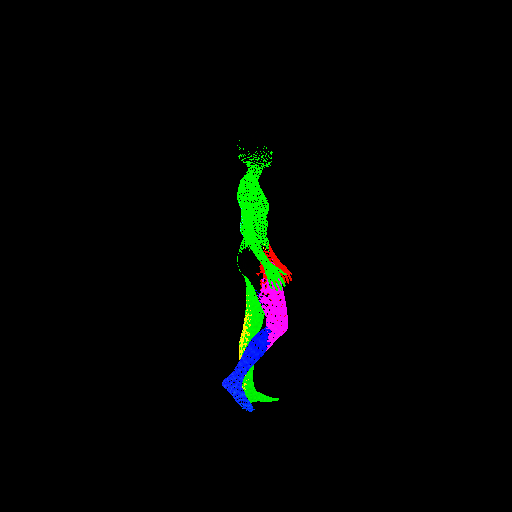

In [4]:
root = '/home2/richa.mishra/4DReconstruction/cloth3d_goodseqs/00491'
out_dir = '/home2/richa.mishra/4DReconstruction/test'
smesh = mesh_init(root, 'Frame000', is_smpl=True)
smesh_next = mesh_init(root, 'Frame003', is_smpl=True)
#smesh.export(file_obj='/home2/richa.mishra/4DReconstruction/scurr.obj')
#smesh_next.export(file_obj = '/home2/richa.mishra/4DReconstruction/snext.obj')

intersections, ray_param, ray_intersect_param, scene = get_peeled_intersections(root, 'Frame000', is_smpl=True)
intersections2, ray_param2, ray_intersect_param2, scene2 = get_peeled_intersections(root, 'Frame002', is_smpl=True)

scf, K = get_scf_peels(root, 'Frame000', 'Frame003',
                             intersections, ray_param,
                             ray_intersect_param, scene, out_dir)

smpl_depth_curr, _ = get_depth_peels(root, 'Frame000', intersections, ray_param, ray_intersect_param, scene, out_dir, is_smpl=True)
smpl_depth_next, _ = get_depth_peels(root, 'Frame003', intersections2, ray_param2, ray_intersect_param2, scene2, out_dir, is_smpl=True)

scf_image1 = Image.fromarray((np.uint8(scf[0]*500))).convert('RGB')

scf_image1

In [13]:
mask = torch.where(torch.tensor(smpl_depth_curr[0])>0)
mask2 = torch.where(torch.tensor(smpl_depth_next[0])>0)

y, x = mask
ones = torch.ones_like(x)
im_points = torch.stack((x, y, ones), 0).float()
K = torch.tensor(K).float()

world_points = (torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ (im_points * smpl_depth_curr[0][mask]))#.cpu().numpy()
world_points_next_gt = (torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ (im_points * smpl_depth_next[0][mask]))#.cpu().numpy()
world_points_next = (world_points.T + scf[0][mask]).T
print(world_points_next_gt.shape)
im_points_next = K @ extrinsic @ world_points_next
im_points = K @ extrinsic @ world_points



torch.Size([3, 8589])


In [5]:
def get_grid(batchsize, rows, cols, dtype=torch.float32):
    hor = torch.linspace(-1.0, 1.0, cols)
    hor.requires_grad = False
    hor = hor.view(1, 1, 1, cols)
    hor = hor.expand(batchsize, 1, rows, cols)
    ver = torch.linspace(-1.0, 1.0, rows)
    ver.requires_grad = False
    ver = ver.view(1, 1, rows, 1)
    ver = ver.expand(batchsize, 1, rows, cols)

    t_grid = torch.cat([hor, ver], 1)
    t_grid.requires_grad = False

    if dtype == torch.float16: t_grid = t_grid.half()
    return t_grid#.cuda(gpu_id)

In [6]:
x, y = torch.meshgrid(torch.arange(0, smpl_depth_curr[0].shape[1]),
                      torch.arange(0, smpl_depth_curr[0].shape[0]))

x = x.reshape(-1)
y = y.reshape(-1)
ones = torch.ones_like(x)
im_points = torch.stack((y, x, ones), 0).float()
K = torch.tensor(K).float()

world_points = ((torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ im_points) * smpl_depth_curr[0].reshape(-1))#.cpu().numpy()
#world_points_next_gt = ((torch.linalg.inv(extrinsic) @ torch.linalg.inv(K) @ im_points) * smpl_depth_next[0].reshape(-1)).cpu().numpy()
#world_points = (torch.linalg.inv(K) @ (im_points * smpl_depth_curr[0].reshape(-1))).cpu().numpy()
world_points_next = (world_points.T + scf[0].reshape(-1, 3)).T
im_points_next = K @ extrinsic @ world_points_next

#mask2 = torch.where(torch.tensor(smpl_depth_next[0])>0)

#y2, x2 = mask2
#mask_a = torch.zeros(512,512)
#mask_a[y2,x2] = 1
#mask_a = mask_a.reshape(1, 512, 512).unsqueeze(0)

#im_points_next_masked = im_points_next

print(world_points_next.shape)

torch.Size([3, 262144])


8589


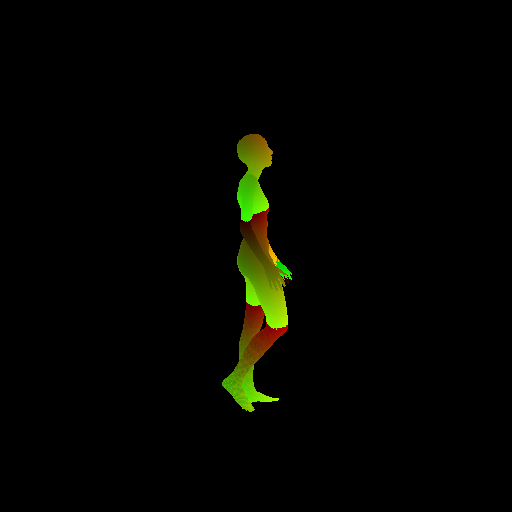

In [7]:
im = im_points_next.reshape(3,512,512).permute(1,2,0)
print(len(torch.where(im_points_next[2,:]>0)[0]))
image1 = Image.fromarray((np.uint8(im))).convert('RGB')
image1

In [29]:
u, v = im_points_next[:2, :]/ (im_points_next[2, :] + 1e-8)
u = (u.reshape(1, 512, 512).unsqueeze(0))
v = (v.reshape(1, 512, 512).unsqueeze(0))
print(u.shape, torch.min(u), torch.max(u), torch.min(v), torch.max(v), torch.max(im_points_next[2,:]))

flow = torch.cat([u, v], dim=1)
print(flow.shape)

mn = torch.min(flow)
mx = torch.max(flow)
print(mn, mx)
scf1 = (2*(flow)-511)/511
print(torch.max(scf1), torch.min(scf1))

torch.Size([1, 1, 512, 512]) tensor(0.) tensor(298.1389) tensor(0.) tensor(411.4753) tensor(2.7975)
torch.Size([1, 2, 512, 512])
tensor(0.) tensor(411.4753)
tensor(0.6105) tensor(-1.)


In [30]:
image = torch.tensor(smpl_depth_curr[0]).reshape(1, 512, 512).unsqueeze(0)
image.shape

torch.Size([1, 1, 512, 512])

In [31]:
def gridsample(input1, input2):
    #if self.opt.fp16: # not sure if it's necessary
        #return grid_sample(input1.float(), input2.float(), mode='bilinear', padding_mode='border').half()
    #else:
    return grid_sample(input1, input2, mode='bilinear', padding_mode='border')

In [36]:
final_grid = (scf1).permute(0, 2, 3, 1)
print(final_grid.shape)
output = gridsample(next_rgb1, final_grid)

torch.Size([1, 512, 512, 2])


In [37]:
print(output.shape)

torch.Size([1, 3, 512, 512])


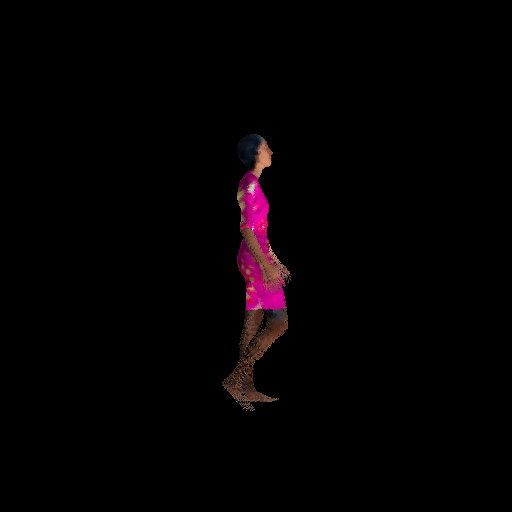

In [38]:
#mask2 = torch.where(torch.tensor(smpl_depth_next[0])>0)
#y, x = mask2
#mask_a = torch.zeros(512,512)
#mask_a[y,x] = 1

image1 = Image.fromarray((np.uint8(output[0,:,:,:].permute(1,2,0)))).convert('RGB')
image1.save(out_dir + '/' + 'rgb_01_frame2.png')
image1

In [25]:
torch.max(curr_rgb1), torch.min(output[0,:,:,:]), torch.max(u), torch.max(v)

(tensor(255.), tensor(0.), tensor(298.1389), tensor(411.4753))

tensor(0.0132)
torch.Size([1, 3, 512, 512])
tensor(0.0180)


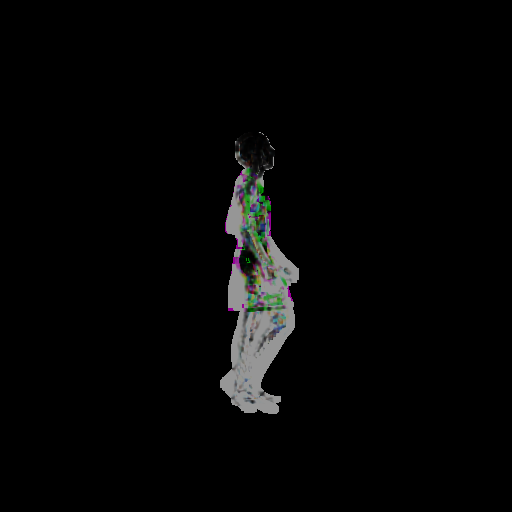

In [39]:
ssim_ = ssim(output, next_rgb1, window_size=5)
ssim_loss = SSIM(5, reduction='mean')
print(ssim_loss(output, curr_rgb1))
print(ssim_.shape)
print(torch.mean(ssim_))
image1 = Image.fromarray((np.uint8(ssim_[0,:,:,:].permute(1,2,0)*300))).convert('RGB')
image1


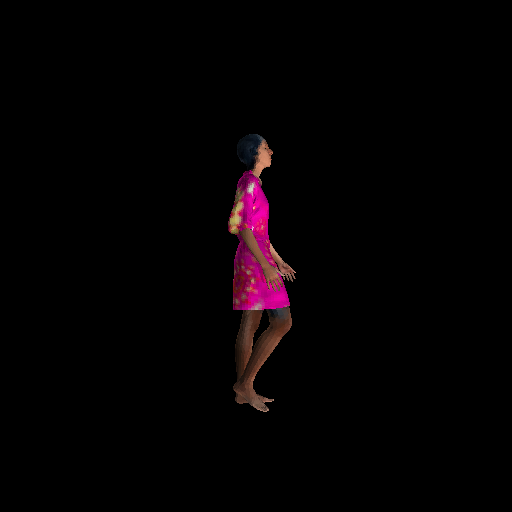

In [17]:
image1 = Image.fromarray((np.uint8(next_rgb1.reshape(3,512,512).permute(1,2,0)))).convert('RGB')
image1

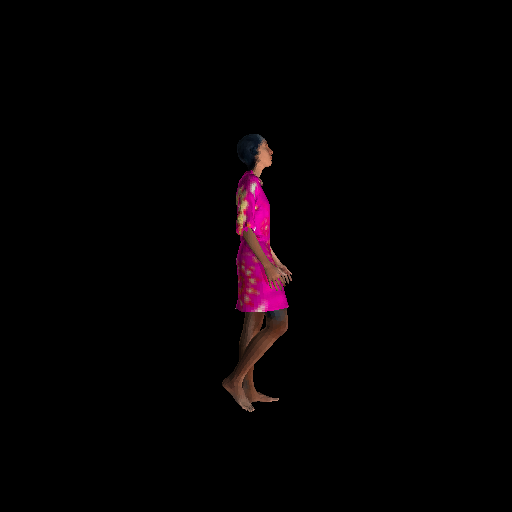

In [25]:
image1 = Image.fromarray((np.uint8(curr_rgb1.reshape(3,512,512).permute(1,2,0)))).convert('RGB')
image1

In [33]:
len(torch.where(output[0,0,:,:]>0)[0])

254248

In [34]:
torch.max(output[0,0,:,:])

tensor(2.3010)

In [38]:
np.max(smpl_depth_next[0])

2.797478